In [1]:
import sys
from pathlib import Path

import pandas as pd

sys.path.append(str(Path().absolute().parent / "src"))


from brainrnaseq_specificity import (
    create_enrichment_dataframe,
    map_hgnc_ids,
    process_hgnc_data,
)
from config import MISSING_FASTA_SEQUENCES, hgnc_ids, high_fractions, low_fractions
from deeptmhmm_localization import (
    get_localization_data,
    identify_localization,
    parse_gz_file,
)
from gtex_specificity import gtex_specificity
from identify_targets import (
    extract_sample_npx,
    generate_protein_dataframe,
    identify_targets,
)
from olink_fractionation import analyze_fractionation
from raw_data_preprocessing import (
    clean_up_raw_data,
    find_ratio,
    plot_protein_fractionation,
)
from specificity_functions import calculate_enrichment

In [2]:
# Get data and output directories relative to notebook
data_dir = Path().absolute().parent / "data"
output_dir = Path().absolute().parent / "outputs"

# Define paths relative to those directories
assay_list_path = data_dir / "231220_ht_panel_assay_list.xlsx"
brain_rna_seq_raw_path = data_dir / "240411_brain_rna_seq_raw.csv"
output_directory = output_dir / "ht_output"
plate_layout_path = data_dir / "231204_Walt_Olink_HT_Plate.xlsx"
raw_data = data_dir / "240214_Walt_Olink_HT_Raw.parquet"
uniprot_fasta_database = data_dir / "uniprot_fasta_database.gz"
gtex_path = data_dir / "GTEx_Analysis_v10_RNASeQCv2.4.2_gene_median_tpm.gct.gz"
lod_path = data_dir / "Explore HT_Fixed LOD_2024-06-19.csv"

In [3]:
# SI Table 1

ht_data = pd.read_parquet(raw_data)
plate_layout = pd.read_excel(plate_layout_path)
data = pd.merge(ht_data, plate_layout, how="left", on="SampleID")
healthy_data = data[data["Health"] == "Healthy"]
si_table_1 = healthy_data.drop(["Location", "CSF_sample", "Sample", "Patient_ID", "Health"], axis = 1)

In [4]:
# SI Table 2

lod_data = pd.read_csv(lod_path, sep = ";")
si_table_2 = si_table_1.merge(lod_data, on = "Assay", how = "left", suffixes = ("", "_drop"))
si_table_2 = si_table_2.drop(si_table_2.filter(regex='_drop').columns, axis=1)

In [4]:
# Create a tidy dataframe from the raw data file.
tidy_data = clean_up_raw_data(raw_data, plate_layout_path)

In [4]:
# SI Table 4

# Load and process the Brain RNA-Seq data
brain_rna_seq = pd.read_csv(brain_rna_seq_raw_path)
hgnc_uniprot_mapping_data = process_hgnc_data(hgnc_ids)
brain_rna_seq = (
    brain_rna_seq.merge(
        hgnc_uniprot_mapping_data, left_on="id", right_on="hgnc_id", how="inner"
    )
    .dropna(subset=["uniprot_ids"])
    .drop_duplicates(subset=["uniprot_ids"])
)
brain_rna_seq.set_index(
    ["uniprot_ids", "symbol", "name", "alias_symbol", "alias_name"], inplace=True
)
expression_df = create_enrichment_dataframe(brain_rna_seq)

# Calculate tau scores and filter by cutoff
tau_score_cutoff = 0.25
enrichment_values = expression_df.apply(
    lambda row: calculate_enrichment(row, "tau"), axis=1
)
low_tau_proteins = enrichment_values[enrichment_values < tau_score_cutoff]

# Identify proteins with the SEC fractionation pattern indicative of EV association
fractionation_uniprot_ids = analyze_fractionation(
    tidy_data,
    high_fractions,
    low_fractions,
    sample_health="healthy",
    mean_median_individual="individual_median",
)

# Identify protein localizations
fasta_sequences = parse_gz_file(uniprot_fasta_database)
fasta_sequences.update(MISSING_FASTA_SEQUENCES)
assays = pd.read_excel(assay_list_path)
localization_ids = get_localization_data(
    assays, fasta_sequences, ["TMhelix", "internal", "external"], output_directory
)

# Generate categorized protein dataframes
localization_labels = {
    "internal": "internal",
    "TMhelix": "transmembrane",
    "external": "external",
}
protein_dataframes = [
    generate_protein_dataframe(
        low_tau_proteins,
        fractionation_uniprot_ids,
        list(localization_ids[loc_type]),
        label,
        tidy_data,
        high_fractions,
        low_fractions,
    )
    for loc_type, label in localization_labels.items()
]

# Create final table
si_table_4 = pd.concat(protein_dataframes).rename(columns={0: "tau_score"})

<Axes: title={'center': 'Healthy Q9Y2J8 Fractionation Pattern, HT Panel'}, xlabel='Sample Description', ylabel='Delta'>

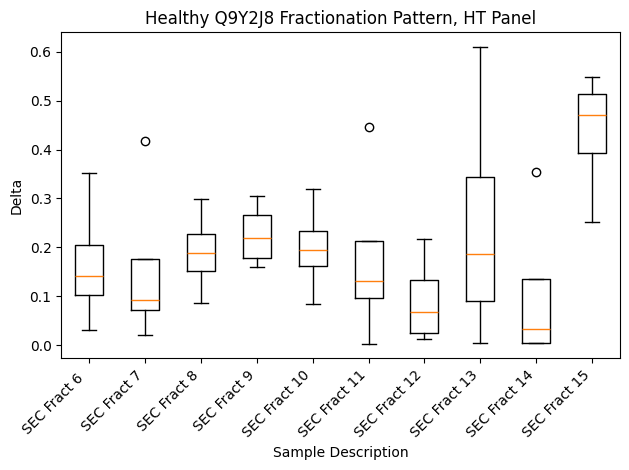

In [5]:
plot_protein_fractionation(tidy_data, "Q9Y2J8")

In [5]:
# SI Table 5

# Load and process Brain RNA-Seq Data
brain_rna_seq = map_hgnc_ids(hgnc_ids, brain_rna_seq_raw_path)
expression_df = create_enrichment_dataframe(brain_rna_seq)

# Group proteins by sub-cellular localization
localization_types = ["TMhelix", "internal", "external"]
localization_ids = {
    loc: identify_localization(assays, loc, output_directory)
    for loc in localization_types
}

# Calculate EV association scores for each sub-cellular localization category
localization_results = []

for loc, uniprot_ids in localization_ids.items():
    proteins_with_fract = set(uniprot_ids) & set(fractionation_uniprot_ids)

    fractionation_scores = [
        find_ratio(tidy_data[protein], high_fractions, low_fractions)
        for protein in proteins_with_fract
    ]

    df = pd.DataFrame(
        {
            "uniprot_ids": list(proteins_with_fract),
            "ev_association_score": fractionation_scores,
        }
    )

    df = df.merge(hgnc_uniprot_mapping_data, on="uniprot_ids")
    df["localization"] = loc

    localization_results.append(df)

# Concatenate dataframes
fract_pattern = pd.concat(localization_results, ignore_index=True)

# # Calculate tau scores and filter by cutoff
tau_score_cutoff = 0.75
enrichment_values = expression_df.apply(
    lambda row: calculate_enrichment(row, "tau"), axis=1
)
high_tau_score = enrichment_values[enrichment_values > tau_score_cutoff]

filtered_expression_df = expression_df[
    expression_df.index.isin(high_tau_score.index.tolist())
]

# Find proteins that are both specific to a cell type
# and display the correct fractionation pattern. Label with cell type
max_col_list = []
uniprots_list = []

for index, row in filtered_expression_df.iterrows():
    max_column = row.idxmax()
    max_col_list.append(max_column)
    uniprots_list.append(index)

cell_type_targets = pd.DataFrame(
    {"cell_type": max_col_list, "uniprot_id": uniprots_list}
)

si_table_5 = fract_pattern.merge(
    cell_type_targets, left_on="uniprot_ids", right_on="uniprot_id", how="inner"
)
high_tau_score = high_tau_score.reset_index()
si_table_5 = si_table_5.merge(high_tau_score, on="uniprot_ids")

# GTex Specificity to determine the extent to which the proteins are
# specific to the brain on a body-wide level
gtex_data = gtex_specificity(gtex_path)
si_table_5 = si_table_5.merge(gtex_data, on="ensembl_gene_id")

si_table_5 = si_table_5.rename(columns={0: "brain_tau_score"})


In [6]:
# generate the data for figure 1d and 1e

# Filter data to include only SEC data collected
# using a sample from a healthy individual
tidy_data_sec = tidy_data[
    (tidy_data.index.get_level_values("Health") == "Healthy")
    & (tidy_data.index.get_level_values("Sample").str.contains("SEC"))
]

# Extract SEC data for the pre-determined EV associated and contaminant proteins
associated_proteins_df = extract_sample_npx(
    ["P08758", "P07355", "P09525", "Q9NP79"], tidy_data_sec
)
contaminant_proteins_df = extract_sample_npx(
    ["P02751", "P00734", "P36955", "P01024"], tidy_data_sec
)

associated_proteins = associated_proteins_df.pivot(columns="protein", index="sample")
contaminant_proteins = contaminant_proteins_df.pivot(columns="protein", index="sample")

In [7]:
# identify targets found inside microglia cells that may be EV associated
# using the raw data file

identify_targets(
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    region="internal",
    cell_type="microglia",
    specificity_metric="tau",
    specificity_cutoff=0.75,
    high_fractions=high_fractions,
    low_fractions=low_fractions,
    sample_health="healthy",
    mean_median_individual="individual_median",
    raw_olink_data_file=raw_data, # using raw data file
    plate_layout_dataframe=plate_layout_path,
    output_directory=output_directory,
)

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

In [8]:
# identify targets found inside microglia cells that may be EV associated using the tidy dataframe

identify_targets(
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    region="internal",
    cell_type="microglia",
    specificity_metric="tau",
    specificity_cutoff=0.75,
    high_fractions=high_fractions,
    low_fractions=low_fractions,
    sample_health="healthy",
    mean_median_individual="individual_median",
    tidy_dataframe=tidy_data, # using the tidy dataframe
    output_directory=output_directory,
)

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

<Axes: title={'center': 'Healthy Q6P0N0 Fractionation Pattern, HT Panel'}, xlabel='Sample Description', ylabel='Delta'>

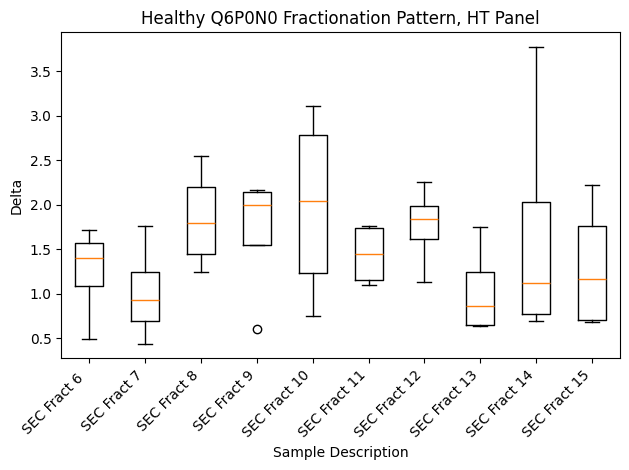

In [9]:
# make a box-and-whisker plot for a target of interest

plot_protein_fractionation(tidy_data, "Q6P0N0")